# Import library and Data Analysis






In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization, Input
from keras.optimizers import Adam
from keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental import preprocessing
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import mixed_precision
mixed_precision.set_global_policy('float32')


print(tf.__version__)

2.15.0


Loading dataset

In [35]:
# Define dataset paths
dataset = {
            "train_data" : "/content/drive/MyDrive/Thesis /dataset_new/train",
             "valid_data" : "/content/drive/MyDrive/Thesis /dataset_new/valid",
             "test_data" : "/content/drive/MyDrive/Thesis /dataset_new/test"
}


all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)


    all_data.append(data.copy())
    data.clear()



train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

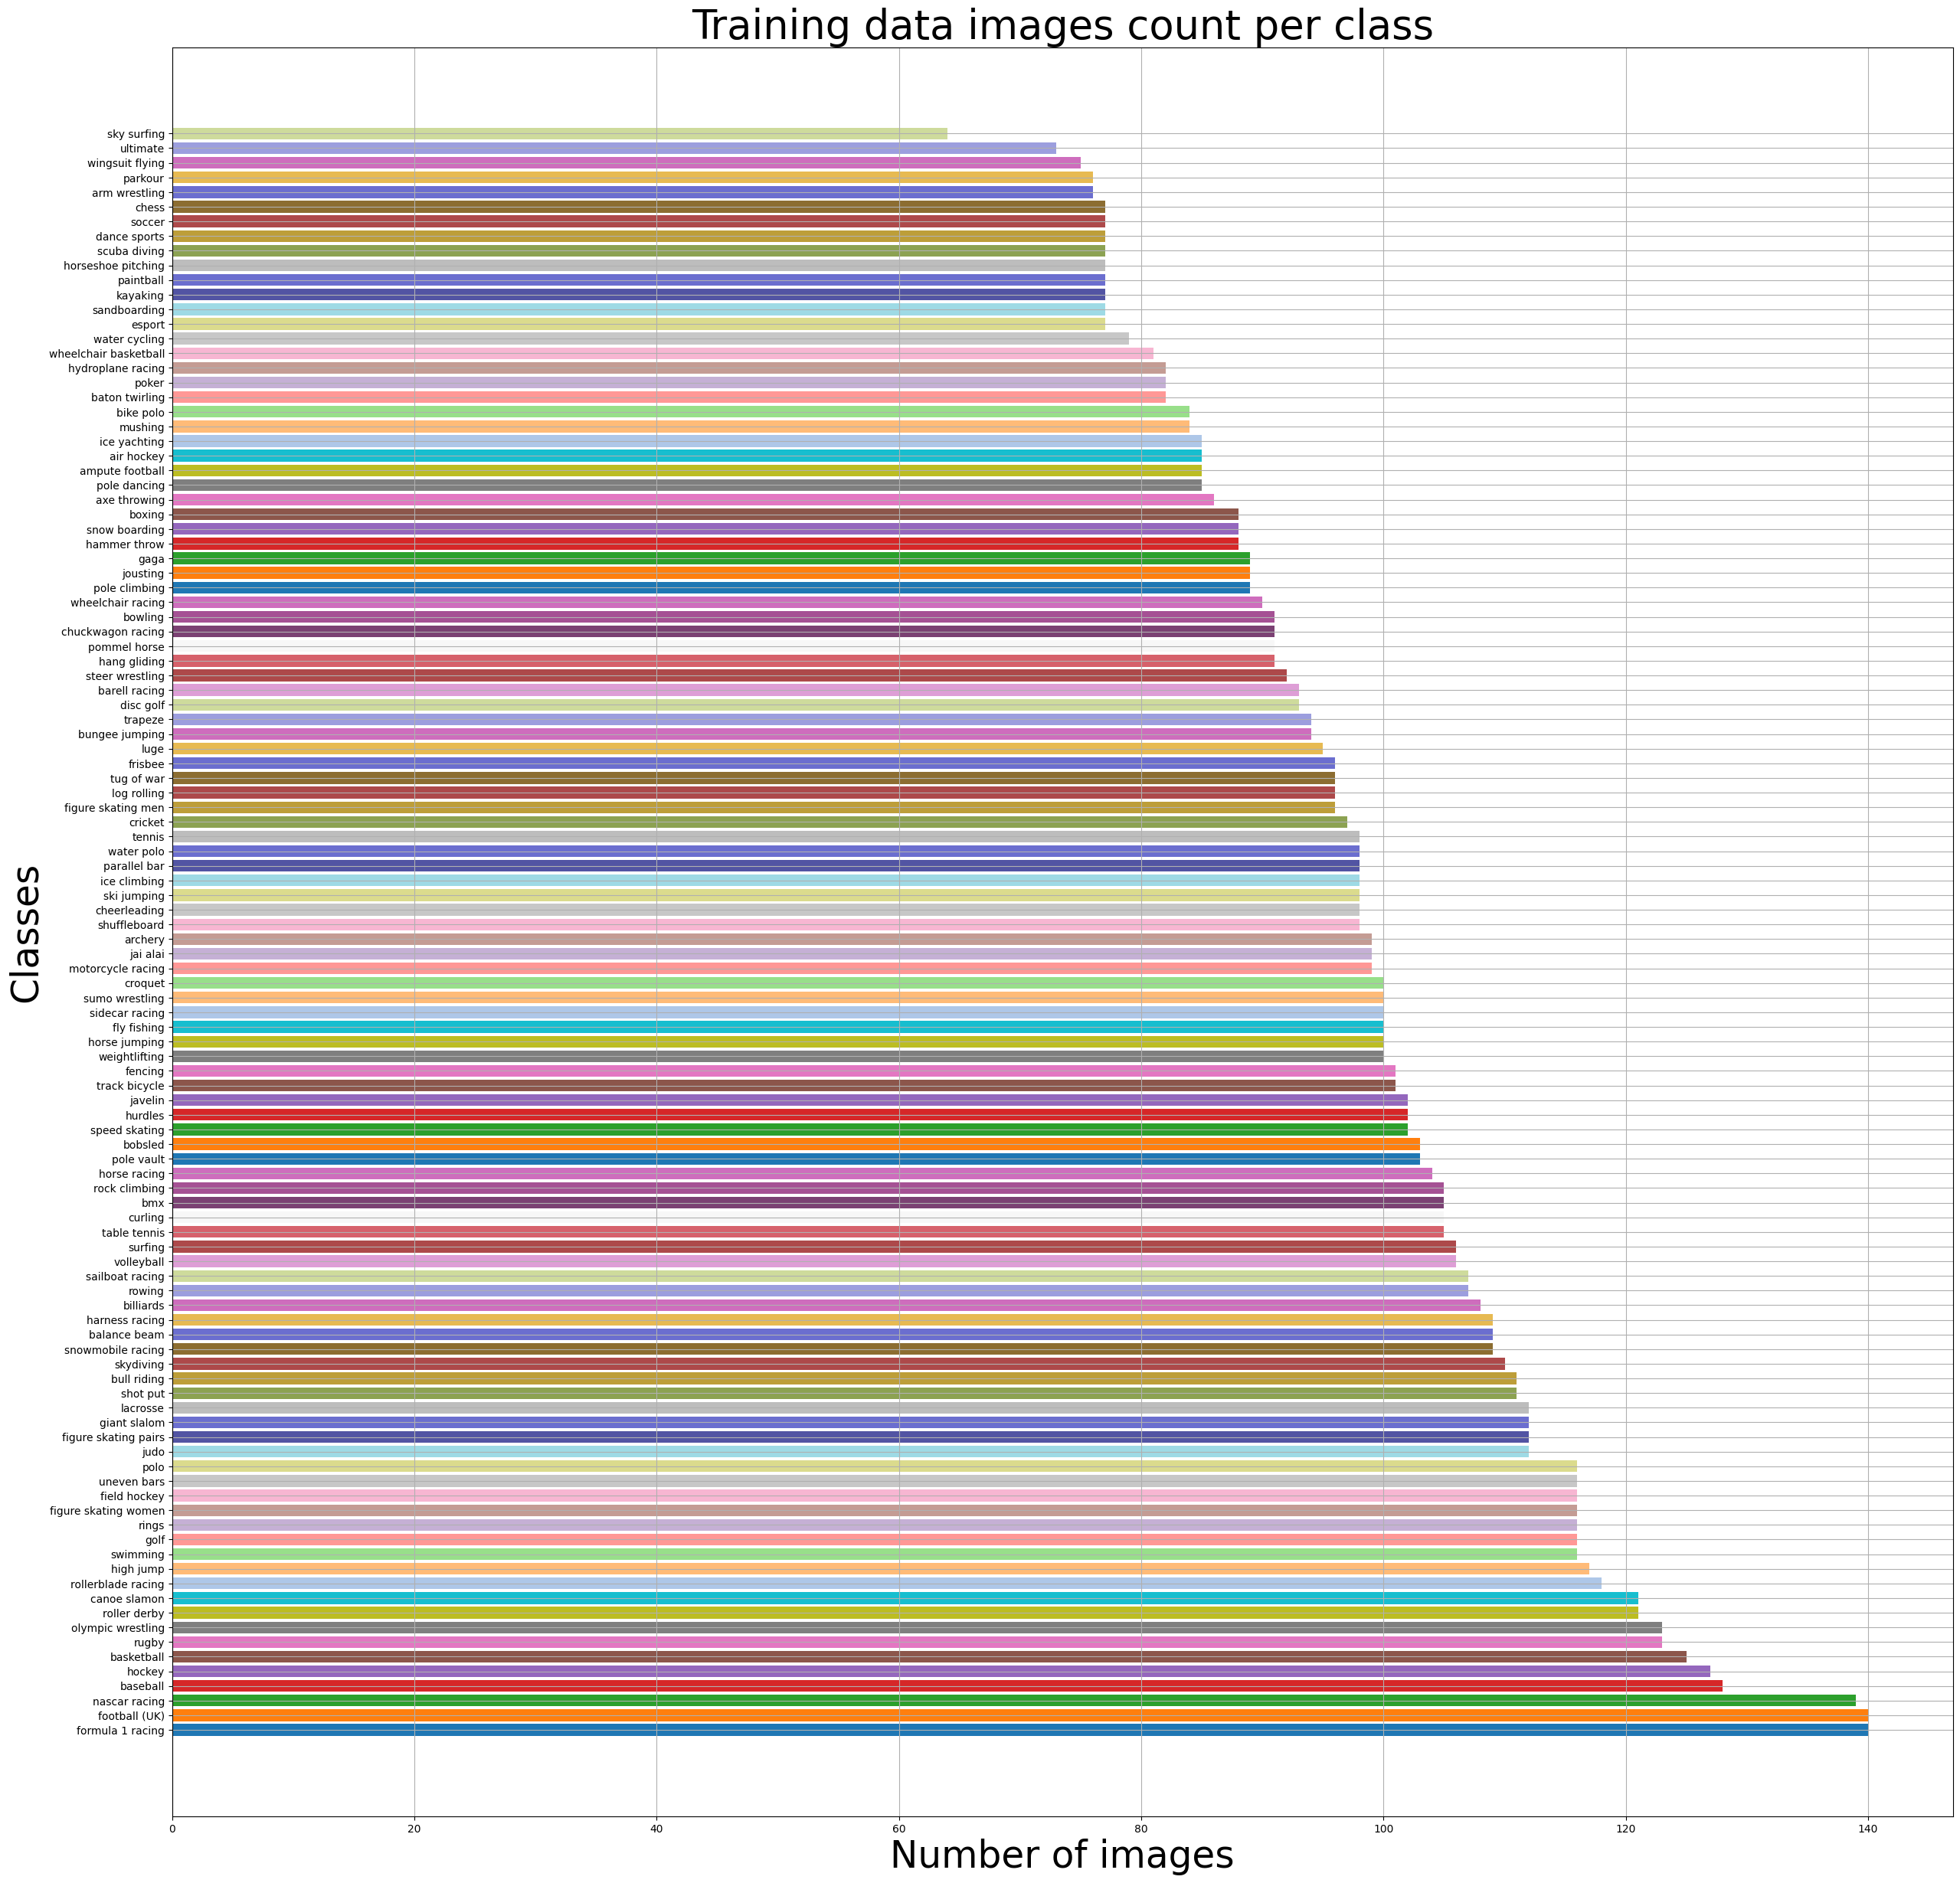

In [19]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()


In [20]:
train_df.sample(n=15, random_state=1)

imgpath             labels  \
3991   /content/drive/MyDrive/Thesis /dataset_new/tra...       pole dancing   
6222   /content/drive/MyDrive/Thesis /dataset_new/tra...      horse jumping   
4663   /content/drive/MyDrive/Thesis /dataset_new/tra...      nascar racing   
1410   /content/drive/MyDrive/Thesis /dataset_new/tra...      speed skating   
10668  /content/drive/MyDrive/Thesis /dataset_new/tra...            archery   
3701   /content/drive/MyDrive/Thesis /dataset_new/tra...             rowing   
1433   /content/drive/MyDrive/Thesis /dataset_new/tra...    steer wrestling   
7330   /content/drive/MyDrive/Thesis /dataset_new/tra...   formula 1 racing   
4906   /content/drive/MyDrive/Thesis /dataset_new/tra...           jousting   
6117   /content/drive/MyDrive/Thesis /dataset_new/tra...            hurdles   
394    /content/drive/MyDrive/Thesis /dataset_new/tra...         volleyball   
6058   /content/drive/MyDrive/Thesis /dataset_new/tra...       horse racing   
4403   /content/drive/MyDrive/Thesis /dataset_new/tra...  motorcycle racing   
597    /content/drive/MyDrive/Thesis /dataset_new/tra...         tug of war   
5281   /content/drive/MyDrive/Thesis /dataset_new/tra...       ice climbing   

       encoded_labels  
3991               69  
6222               45  
4663               62  
1410               91  
10668               2  
3701               77  
1433               92  
7330               35  
4906               54  
6117               48  
394               103  
6058               46  
4403               60  
597               100  
5281               50

In [21]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath             labels
0  /content/drive/MyDrive/Thesis /dataset_new/tra...  wheelchair racing
1  /content/drive/MyDrive/Thesis /dataset_new/tra...  wheelchair racing
2  /content/drive/MyDrive/Thesis /dataset_new/tra...  wheelchair racing
3  /content/drive/MyDrive/Thesis /dataset_new/tra...  wheelchair racing
4  /content/drive/MyDrive/Thesis /dataset_new/tra...  wheelchair racing
(10880, 3)
--------Validation----------
                                             imgpath                 labels
0  /content/drive/MyDrive/Thesis /dataset_new/val...  wheelchair basketball
1  /content/drive/MyDrive/Thesis /dataset_new/val...  wheelchair basketball
2  /content/drive/MyDrive/Thesis /dataset_new/val...  wheelchair basketball
3  /content/drive/MyDrive/Thesis /dataset_new/val...  wheelchair basketball
4  /content/drive/MyDrive/Thesis /dataset_new/val...  wheelchair basketball
(2401, 3)
----------Test--------------
    

Show sample from data

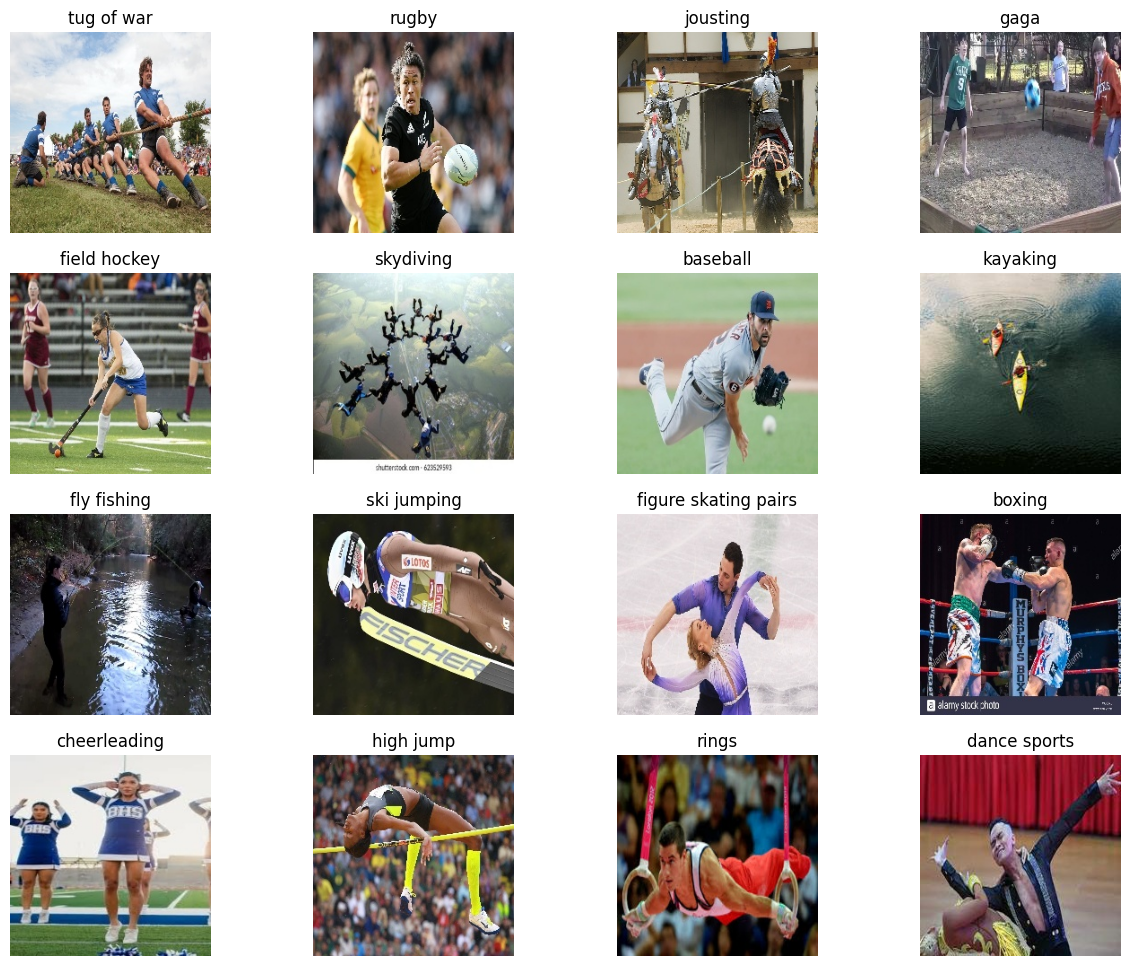

In [22]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

#EfficientNet B0

In [80]:
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [81]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [82]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(350)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_7 (Dense)             (None, 350)               448350    
                                                                 
 activation_2 (Activation)   (None, 350)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 350)               1400

Training: Transfer learning

In [83]:
import time
start_time = time.time()

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save('/content/drive/MyDrive/Thesis /dataset_new/EfficientNetB0.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1088/1088 [==============================] - 56s 44ms/step - loss: 2.0947 - accuracy: 0.5168 - val_loss: 0.7203 - val_accuracy: 0.8097 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 48s 45ms/step - loss: 0.9409 - accuracy: 0.7640 - val_loss: 0.5758 - val_accuracy: 0.8401 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 49s 45ms/step - loss: 0.7339 - accuracy: 0.8131 - val_loss: 0.5299 - val_accuracy: 0.8471 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 49s 45ms/step - loss: 0.6221 - accuracy: 0.8352 - val_loss: 0.4738 - val_accuracy: 0.8734 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 50s 46ms/step - loss: 0.5444 - accuracy: 0.8529 - val_loss: 0.5061 - val_accuracy: 0.8605 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 50s 45ms/step - loss: 0.5268 - accuracy: 0.8548 - val_loss: 0.4491 - val_accuracy: 0.8801 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

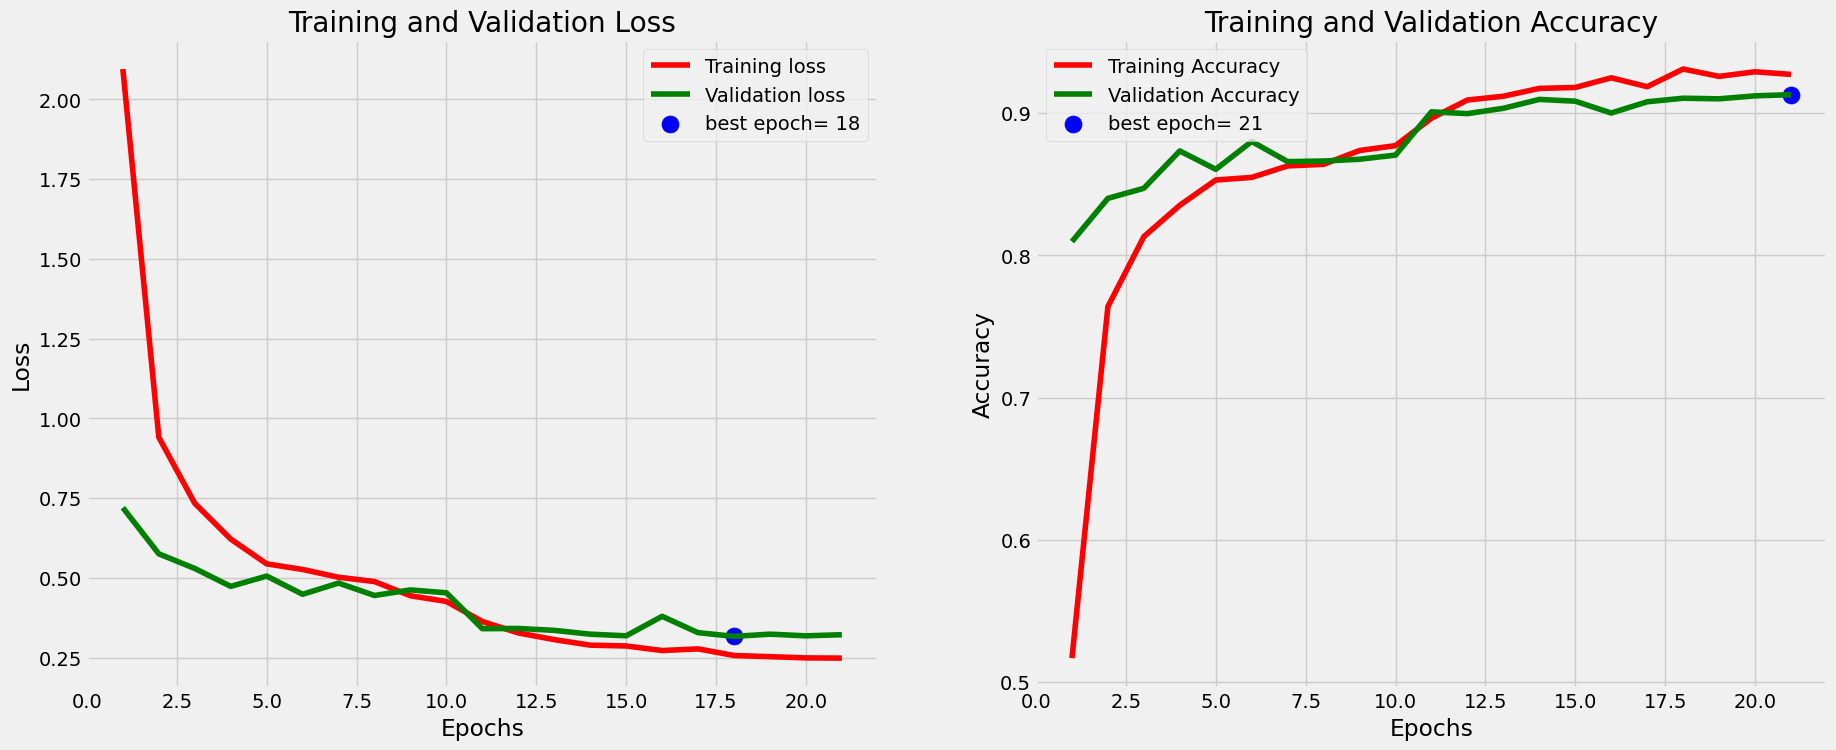

In [84]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


Model Evaluate

In [85]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.26501
Test Accuracy: 92.16%


F1 Score / Recall / Precision

In [86]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

234/234 [==============================] - 9s 33ms/step
F1 Score: 0.9221471979728406
                       precision    recall  f1-score   support

           air hockey       0.94      0.94      0.94        18
      ampute football       0.94      0.94      0.94        18
              archery       1.00      0.90      0.95        21
        arm wrestling       0.89      1.00      0.94        16
         axe throwing       0.86      1.00      0.92        18
         balance beam       0.79      0.96      0.87        24
        barell racing       0.87      1.00      0.93        20
             baseball       0.80      0.86      0.83        28
           basketball       0.76      0.93      0.83        27
       baton twirling       1.00      0.94      0.97        18
            bike polo       0.78      0.78      0.78        18
            billiards       1.00      1.00      1.00        23
                  bmx       1.00      0.68      0.81        22
              bobsled       0.88

In [87]:
# predict labels on EfficientNetB0 test_set
preds = model.predict(test_images)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images.classes
class_labels = list(test_images.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

234/234 [==============================] - 8s 34ms/step
air hockey: 94.44%
ampute football: 94.44%
archery: 90.48%
arm wrestling: 100.00%
axe throwing: 100.00%
balance beam: 95.83%
barell racing: 100.00%
baseball: 85.71%
basketball: 92.59%
baton twirling: 94.44%
bike polo: 77.78%
billiards: 100.00%
bmx: 68.18%
bobsled: 95.45%
bowling: 89.47%
boxing: 100.00%
bull riding: 100.00%
bungee jumping: 100.00%
canoe slamon: 92.31%
cheerleading: 71.43%
chess: 87.50%
chuckwagon racing: 84.21%
cricket: 90.48%
croquet: 95.45%
curling: 100.00%
dance sports: 87.50%
disc golf: 95.00%
esport: 93.75%
fencing: 95.45%
field hockey: 96.00%
figure skating men: 85.71%
figure skating pairs: 66.67%
figure skating women: 92.00%
fly fishing: 100.00%
football (UK): 96.67%
formula 1 racing: 100.00%
frisbee: 95.24%
gaga: 63.16%
giant slalom: 95.83%
golf: 88.00%
hammer throw: 95.00%
hang gliding: 100.00%
harness racing: 95.83%
high jump: 84.00%
hockey: 96.30%
horse jumping: 95.45%
horse racing: 90.91%
horseshoe pitc

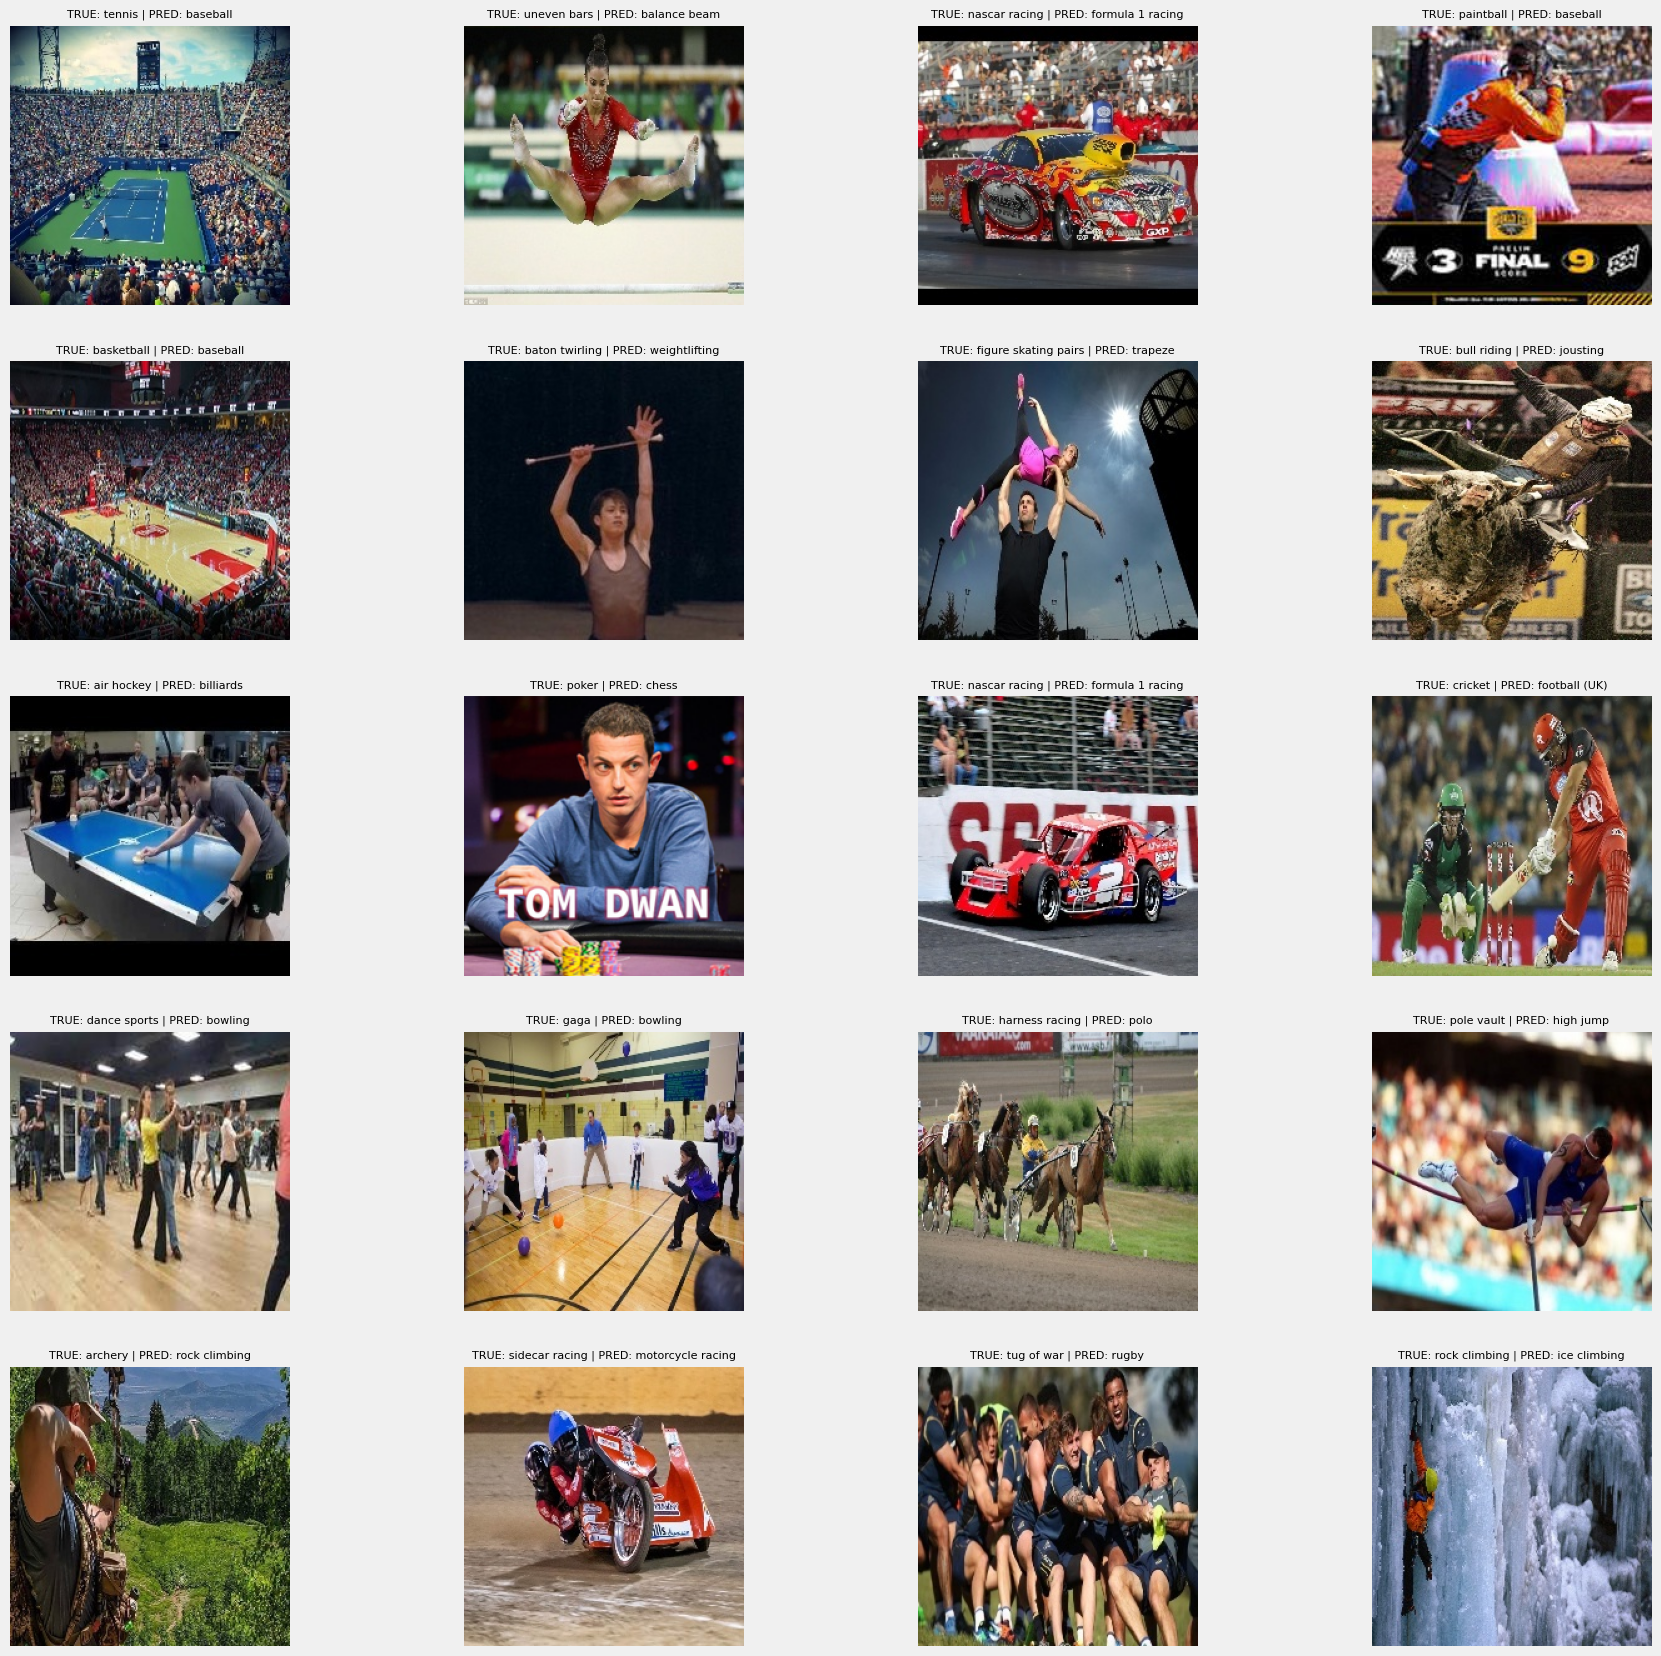

In [88]:
#Print the most confident errors
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

#VGG16

In [89]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_vgg16 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_vgg16 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_vgg16 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [90]:
from keras.applications import VGG16
# Load and modify the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

In [91]:
from keras.layers import GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast
num_classes = len(set(train_images_vgg16.classes))
# Define data augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1),
  RandomZoom(0.1),
  RandomContrast(0.1),
], name='data_augmentation')

# Modify the model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Set training=False for batch norm layers
x = GlobalAveragePooling2D()(x)
x = Dense(350, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 350)               179550    
                                                                 
 batch_normalization_5 (Bat  (None, 350)               1400

Training: Transfer learning

In [92]:
import time
start_time = time.time()

# Train the model
history_vgg16 = model.fit(
    train_images_vgg16,
    steps_per_epoch=len(train_images_vgg16),
    validation_data=val_images_vgg16,
    validation_steps=len(val_images_vgg16),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Thesis /dataset_new/VGG16.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1088/1088 [==============================] - 55s 49ms/step - loss: 3.1066 - accuracy: 0.2853 - val_loss: 2.4002 - val_accuracy: 0.5244 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 53s 49ms/step - loss: 1.8906 - accuracy: 0.5256 - val_loss: 1.7992 - val_accuracy: 0.6293 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 54s 50ms/step - loss: 1.5861 - accuracy: 0.5869 - val_loss: 1.6397 - val_accuracy: 0.6735 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 52s 48ms/step - loss: 1.4033 - accuracy: 0.6297 - val_loss: 1.5215 - val_accuracy: 0.6756 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 52s 48ms/step - loss: 1.2880 - accuracy: 0.6523 - val_loss: 1.3819 - val_accuracy: 0.7076 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 53s 49ms/step - loss: 1.2374 - accuracy: 0.6676 - val_loss: 1.5717 - val_accuracy: 0.7010 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

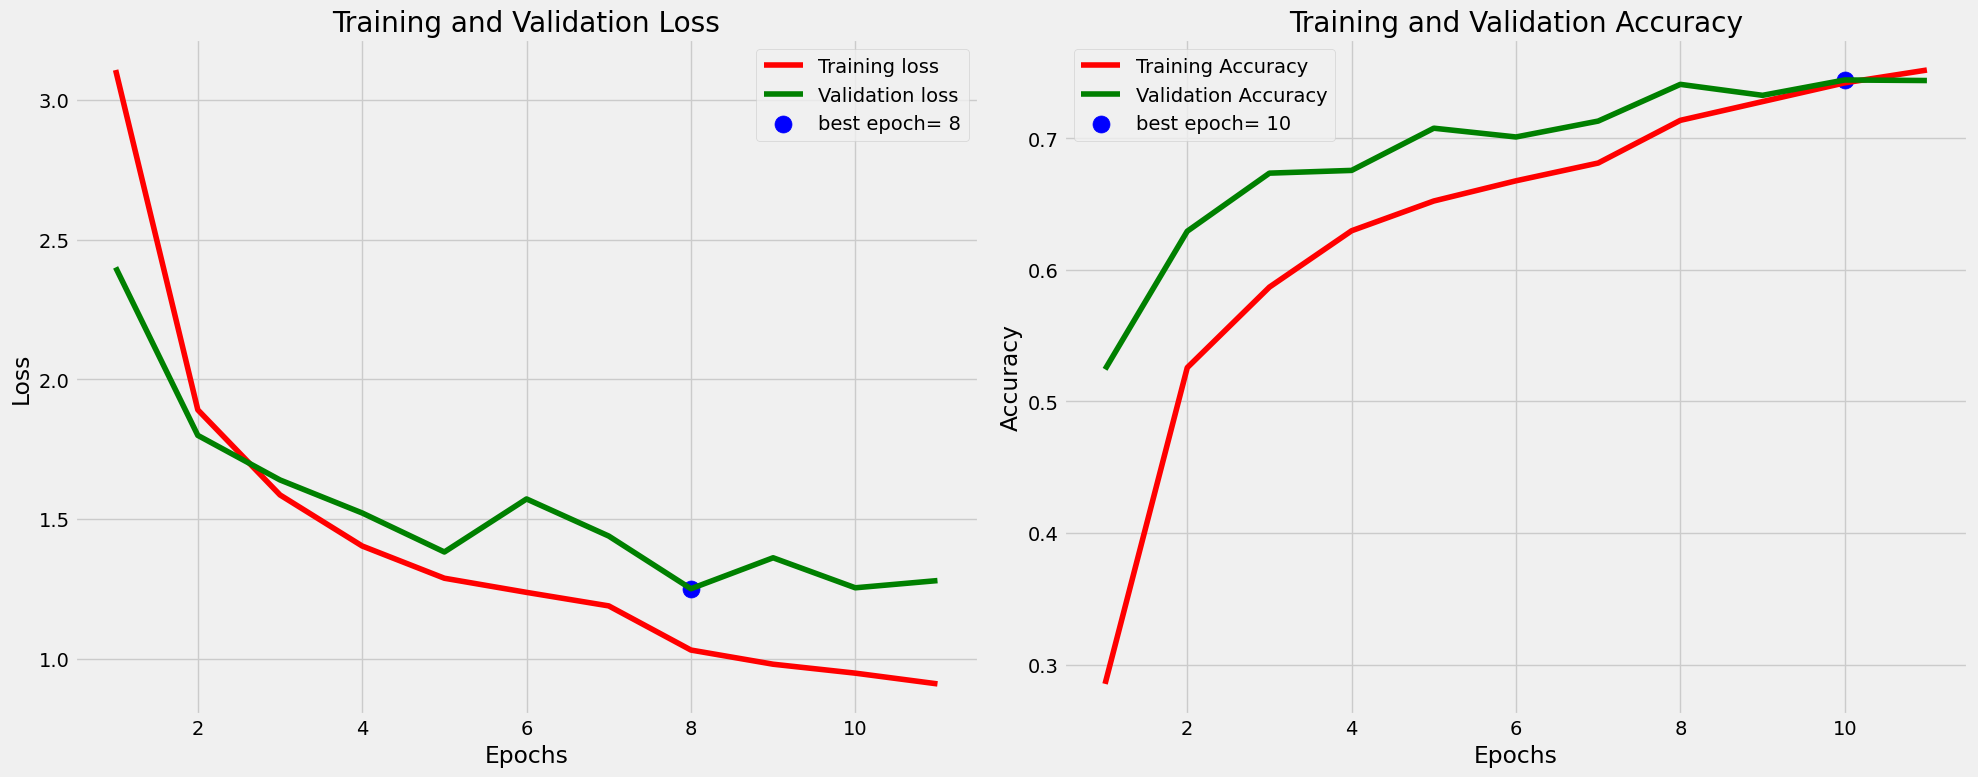

In [93]:
# Corrected variable assignments
tr_acc = history_vgg16.history['accuracy']
tr_loss = history_vgg16.history['loss']
val_acc = history_vgg16.history['val_accuracy']
val_loss = history_vgg16.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

model evaluate

In [94]:
results = model.evaluate(test_images_vgg16, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.23989
Test Accuracy: 75.03%


F1 Score / Recall / Precision

In [95]:
y_true = test_images_vgg16.classes
y_pred = np.argmax(model.predict(test_images_vgg16), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_vgg16.class_indices.keys()))

234/234 [==============================] - 9s 39ms/step
F1 Score: 0.748044505155034
                       precision    recall  f1-score   support

           air hockey       0.81      0.72      0.76        18
      ampute football       0.70      0.89      0.78        18
              archery       0.64      0.86      0.73        21
        arm wrestling       0.78      0.88      0.82        16
         axe throwing       0.72      1.00      0.84        18
         balance beam       0.73      0.67      0.70        24
        barell racing       0.67      0.90      0.77        20
             baseball       0.68      0.68      0.68        28
           basketball       0.63      0.63      0.63        27
       baton twirling       0.82      0.78      0.80        18
            bike polo       0.41      1.00      0.58        18
            billiards       0.82      1.00      0.90        23
                  bmx       1.00      0.27      0.43        22
              bobsled       0.64 

In [96]:
# predict labels on vgg16 test_set
preds = model.predict(test_images_vgg16)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images_vgg16.classes
class_labels = list(test_images_vgg16.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

234/234 [==============================] - 9s 40ms/step
air hockey: 72.22%
ampute football: 88.89%
archery: 85.71%
arm wrestling: 87.50%
axe throwing: 100.00%
balance beam: 66.67%
barell racing: 90.00%
baseball: 67.86%
basketball: 62.96%
baton twirling: 77.78%
bike polo: 100.00%
billiards: 100.00%
bmx: 27.27%
bobsled: 63.64%
bowling: 63.16%
boxing: 52.63%
bull riding: 91.67%
bungee jumping: 70.00%
canoe slamon: 100.00%
cheerleading: 90.48%
chess: 81.25%
chuckwagon racing: 36.84%
cricket: 80.95%
croquet: 77.27%
curling: 82.61%
dance sports: 56.25%
disc golf: 90.00%
esport: 25.00%
fencing: 95.45%
field hockey: 80.00%
figure skating men: 90.48%
figure skating pairs: 66.67%
figure skating women: 88.00%
fly fishing: 72.73%
football (UK): 83.33%
formula 1 racing: 43.33%
frisbee: 71.43%
gaga: 68.42%
giant slalom: 91.67%
golf: 72.00%
hammer throw: 80.00%
hang gliding: 100.00%
harness racing: 87.50%
high jump: 80.00%
hockey: 85.19%
horse jumping: 40.91%
horse racing: 40.91%
horseshoe pitching: 

#ResNet50

In [142]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_resnet50 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_resnet50 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_resnet50 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [143]:
from keras.applications import ResNet50
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

In [144]:
num_classes = len(set(train_images_resnet50.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Load pre-trained ResNet50 model
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_resnet50.layers:
    layer.trainable = False

inputs_resnet50 = layers.Input(shape=(224, 224, 3), name='inputLayer')
x_resnet50 = augment(inputs_resnet50)
pretrain_out_resnet50 = pretrained_model_resnet50(x_resnet50, training=False)
x_resnet50 = layers.Dense(350, activation="relu")(pretrain_out_resnet50)
x_resnet50 = layers.BatchNormalization()(x_resnet50)
x_resnet50 = layers.Dropout(0.25)(x_resnet50)
x_resnet50 = layers.Dense(num_classes, activation='softmax', dtype=tf.float32, name='activationLayer')(x_resnet50)

model_resnet50 = Model(inputs=inputs_resnet50, outputs=x_resnet50)

model_resnet50.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model_resnet50.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_17 (Dense)            (None, 350)               717150    
                                                                 
 batch_normalization_198 (B  (None, 350)               1400      
 atchNormalization)                                              
                                                                 
 dropout_10 (Dropout)        (None, 350)               0  

Transfer learning

In [145]:
import time
start_time = time.time()

history_resnet50 = model_resnet50.fit(
    train_images_resnet50,
    steps_per_epoch=len(train_images_resnet50),
    validation_data=val_images_resnet50,
    validation_steps=len(val_images_resnet50),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_resnet50.save_weights('/content/drive/MyDrive/Thesis /dataset_new/ResNet50.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1088/1088 [==============================] - 61s 52ms/step - loss: 2.6220 - accuracy: 0.3972 - val_loss: 1.1759 - val_accuracy: 0.6797 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 54s 50ms/step - loss: 1.4978 - accuracy: 0.6269 - val_loss: 1.2706 - val_accuracy: 0.6631 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 54s 50ms/step - loss: 1.1857 - accuracy: 0.6897 - val_loss: 0.8829 - val_accuracy: 0.7476 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 54s 50ms/step - loss: 1.0532 - accuracy: 0.7211 - val_loss: 0.8417 - val_accuracy: 0.7539 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 54s 50ms/step - loss: 0.9676 - accuracy: 0.7383 - val_loss: 0.7599 - val_accuracy: 0.7734 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 55s 50ms/step - loss: 0.9151 - accuracy: 0.7491 - val_loss: 0.8090 - val_accuracy: 0.7564 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

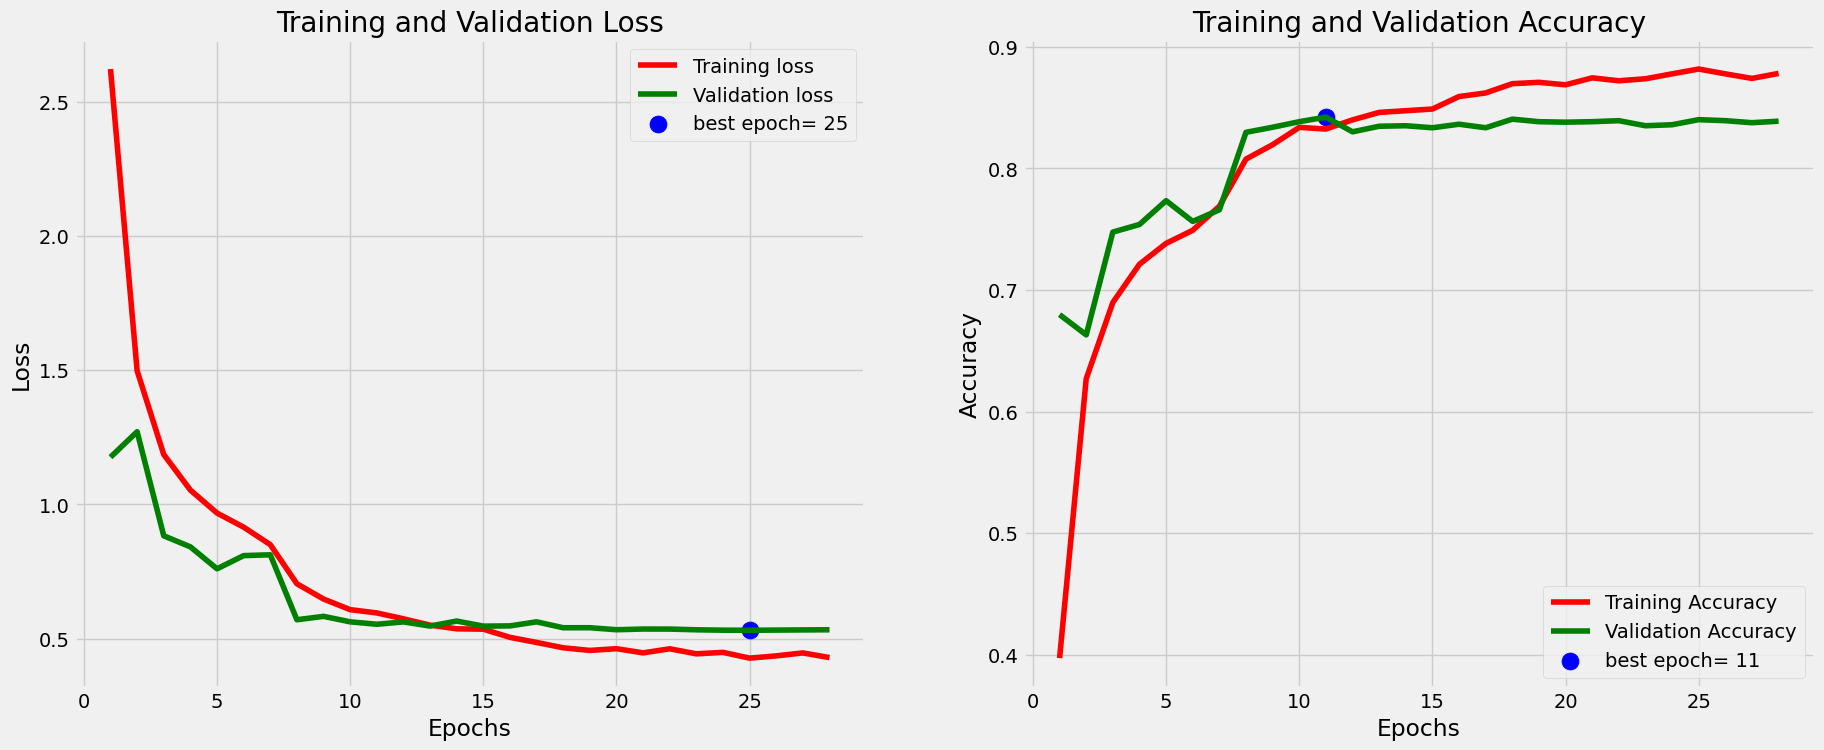

In [146]:
# Define needed variables
tr_acc = history_resnet50.history['accuracy']
tr_loss = history_resnet50.history['loss']
val_acc = history_resnet50.history['val_accuracy']
val_loss = history_resnet50.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

  model evaluate

In [147]:
results_resnet50 = model_resnet50.evaluate(test_images_resnet50, verbose=0)
print("ResNet50 Model - Test Loss: {:.5f}".format(results_resnet50[0]))
print("ResNet50 Model - Test Accuracy: {:.2f}%".format(results_resnet50[1] * 100))

ResNet50 Model - Test Loss: 0.53565
ResNet50 Model - Test Accuracy: 84.63%


F1 Score / Recall / Precision

In [148]:
y_true = test_images_resnet50.classes
y_pred = np.argmax(model_resnet50.predict(test_images_resnet50), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_resnet50.class_indices.keys()))

234/234 [==============================] - 10s 39ms/step
F1 Score: 0.8442084913291394
                       precision    recall  f1-score   support

           air hockey       0.77      0.94      0.85        18
      ampute football       0.85      0.94      0.89        18
              archery       0.79      0.90      0.84        21
        arm wrestling       0.84      1.00      0.91        16
         axe throwing       0.89      0.94      0.92        18
         balance beam       0.70      0.96      0.81        24
        barell racing       0.83      1.00      0.91        20
             baseball       0.90      0.68      0.78        28
           basketball       0.83      0.70      0.76        27
       baton twirling       0.88      0.83      0.86        18
            bike polo       0.68      0.83      0.75        18
            billiards       0.88      1.00      0.94        23
                  bmx       1.00      0.41      0.58        22
              bobsled       0.6

In [149]:
#predict labels on resnet50 test_set
preds =  model_resnet50.predict(test_images_resnet50)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images_resnet50.classes
class_labels = list(test_images_resnet50.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

234/234 [==============================] - 10s 41ms/step
air hockey: 94.44%
ampute football: 94.44%
archery: 90.48%
arm wrestling: 100.00%
axe throwing: 94.44%
balance beam: 95.83%
barell racing: 100.00%
baseball: 67.86%
basketball: 70.37%
baton twirling: 83.33%
bike polo: 83.33%
billiards: 100.00%
bmx: 40.91%
bobsled: 59.09%
bowling: 84.21%
boxing: 84.21%
bull riding: 91.67%
bungee jumping: 95.00%
canoe slamon: 92.31%
cheerleading: 76.19%
chess: 87.50%
chuckwagon racing: 84.21%
cricket: 95.24%
croquet: 95.45%
curling: 100.00%
dance sports: 75.00%
disc golf: 95.00%
esport: 75.00%
fencing: 90.91%
field hockey: 84.00%
figure skating men: 95.24%
figure skating pairs: 50.00%
figure skating women: 96.00%
fly fishing: 95.45%
football (UK): 96.67%
formula 1 racing: 80.00%
frisbee: 90.48%
gaga: 63.16%
giant slalom: 95.83%
golf: 68.00%
hammer throw: 95.00%
hang gliding: 100.00%
harness racing: 100.00%
high jump: 76.00%
hockey: 100.00%
horse jumping: 72.73%
horse racing: 90.91%
horseshoe pitchin

#MobileNet V3 Large

In [134]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input)

BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_mobilenet = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_mobilenet = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_mobilenet = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [135]:
from keras.applications import MobileNetV3Large

pretrained_model_mobilenetv3 = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_mobilenetv3.layers:
    layer.trainable = False

In [136]:
from keras.layers import GlobalAveragePooling2D
num_classes = len(set(train_images_mobilenet.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Building the model
inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
x = augment(inputs)
x = pretrained_model_mobilenetv3(x, training=False)
x = layers.Dense(350, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
print(model.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 dense_15 (Dense)            (None, 350)               336350    
                                                                 
 batch_normalization_197 (B  (None, 350)               1400      
 atchNormalization)                                              
                                                           

Transfer learning

In [137]:
import time
start_time = time.time()

# Training the model
history = model.fit(
    train_images_mobilenet,
    steps_per_epoch=len(train_images_mobilenet),
    validation_data=val_images_mobilenet,
    validation_steps=len(val_images_mobilenet),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Thesis /dataset_new/MobileNetV3Large.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1088/1088 [==============================] - 51s 43ms/step - loss: 2.2986 - accuracy: 0.4629 - val_loss: 0.8181 - val_accuracy: 0.8013 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 46s 42ms/step - loss: 1.0132 - accuracy: 0.7392 - val_loss: 0.5838 - val_accuracy: 0.8451 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 46s 42ms/step - loss: 0.7817 - accuracy: 0.7879 - val_loss: 0.5390 - val_accuracy: 0.8567 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 45s 42ms/step - loss: 0.6612 - accuracy: 0.8125 - val_loss: 0.4617 - val_accuracy: 0.8709 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 45s 42ms/step - loss: 0.5842 - accuracy: 0.8318 - val_loss: 0.4309 - val_accuracy: 0.8776 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 46s 42ms/step - loss: 0.5262 - accuracy: 0.8472 - val_loss: 0.4508 - val_accuracy: 0.8855 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

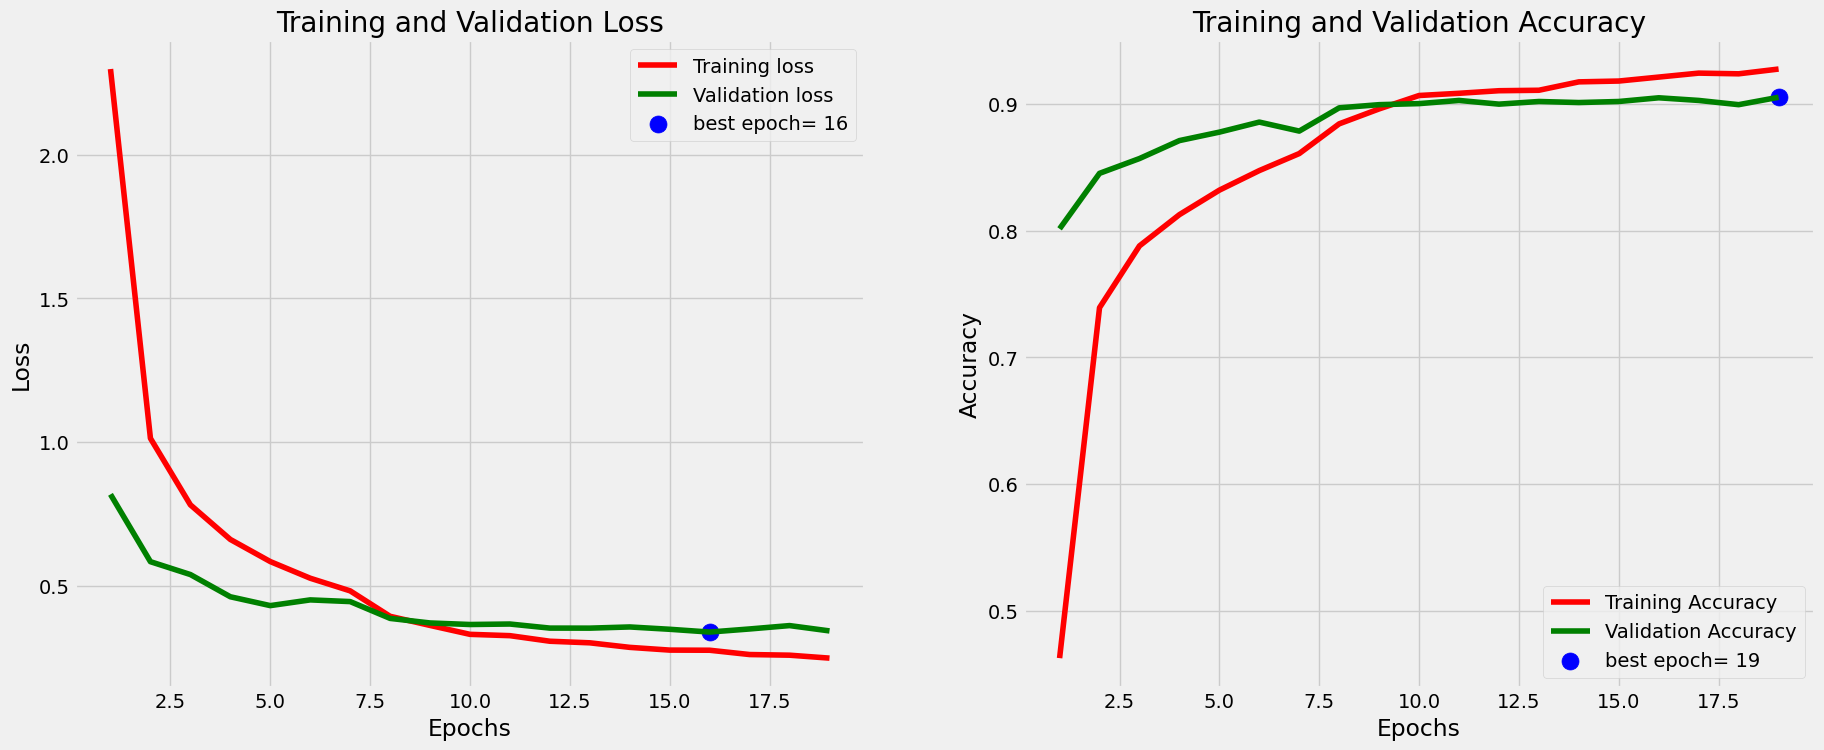

In [138]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

model evaluate

In [139]:
results_mobilenet = model.evaluate(test_images_mobilenet, verbose=0)
print("MobileNet Model - Test Loss: {:.5f}".format(results_mobilenet[0]))
print("MobileNet Model - Test Accuracy: {:.2f}%".format(results_mobilenet[1] * 100))

MobileNet Model - Test Loss: 0.34947
MobileNet Model - Test Accuracy: 90.66%


F1 Score / Recall / Precision


In [140]:
y_true = test_images_mobilenet.classes
y_pred = np.argmax(model.predict(test_images_mobilenet), axis=1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_mobilenet.class_indices.keys()))

234/234 [==============================] - 9s 33ms/step
F1 Score: 0.9048211907936432
                       precision    recall  f1-score   support

           air hockey       0.88      0.78      0.82        18
      ampute football       0.94      0.89      0.91        18
              archery       0.95      1.00      0.98        21
        arm wrestling       0.79      0.94      0.86        16
         axe throwing       1.00      0.94      0.97        18
         balance beam       1.00      0.88      0.93        24
        barell racing       0.90      0.95      0.93        20
             baseball       0.86      0.89      0.88        28
           basketball       0.77      0.89      0.83        27
       baton twirling       1.00      0.89      0.94        18
            bike polo       0.75      1.00      0.86        18
            billiards       0.96      1.00      0.98        23
                  bmx       1.00      0.50      0.67        22
              bobsled       0.79

In [141]:
# predict labels on MobileNetV3 Large test_set
preds = model.predict(test_images_mobilenet)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images_mobilenet.classes
class_labels = list(test_images_mobilenet.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

234/234 [==============================] - 8s 33ms/step
air hockey: 77.78%
ampute football: 88.89%
archery: 100.00%
arm wrestling: 93.75%
axe throwing: 94.44%
balance beam: 87.50%
barell racing: 95.00%
baseball: 89.29%
basketball: 88.89%
baton twirling: 88.89%
bike polo: 100.00%
billiards: 100.00%
bmx: 50.00%
bobsled: 100.00%
bowling: 89.47%
boxing: 100.00%
bull riding: 87.50%
bungee jumping: 75.00%
canoe slamon: 100.00%
cheerleading: 76.19%
chess: 68.75%
chuckwagon racing: 84.21%
cricket: 76.19%
croquet: 95.45%
curling: 95.65%
dance sports: 75.00%
disc golf: 95.00%
esport: 100.00%
fencing: 100.00%
field hockey: 96.00%
figure skating men: 80.95%
figure skating pairs: 62.50%
figure skating women: 92.00%
fly fishing: 100.00%
football (UK): 93.33%
formula 1 racing: 100.00%
frisbee: 85.71%
gaga: 68.42%
giant slalom: 95.83%
golf: 88.00%
hammer throw: 95.00%
hang gliding: 100.00%
harness racing: 100.00%
high jump: 88.00%
hockey: 96.30%
horse jumping: 90.91%
horse racing: 95.45%
horseshoe pit

#Inception V3

In [113]:
BATCH_SIZE = 10
IMAGE_SIZE = (299, 299)

generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [114]:
from keras.applications import InceptionV3
# Load the pretrained model
pretrained_model = InceptionV3(
    input_shape=(299, 299, 3),
    include_top=False,  # We don't need the pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

87910968/87910968 [==============================] - 3s 0us/step


In [115]:
# Data Augmentation Step
augment = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Define input shape and create input layer
inputs_inception_v3 = Input(shape=(299, 299, 3), name='inputLayer')
x_inception = augment(inputs_inception_v3)

# Load InceptionV3 Base Model
base_model = InceptionV3(include_top=False, input_tensor=x_inception, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add classification layers on top of InceptionV3
x_inception = base_model.output
x_inception = tf.keras.layers.GlobalAveragePooling2D()(x_inception)
x_inception = Dense(350, activation='relu')(x_inception)
x_inception = BatchNormalization()(x_inception)
x_inception = Dropout(0.25)(x_inception)

# Dynamically set the number of classes based on your dataset
num_classes = len(set(train_images_inception_v3.classes))
x_inception = Dense(num_classes, activation='softmax', dtype=tf.float32, name='activationLayer')(x_inception)

# Create the final model
model_inception_v3 = Model(inputs=inputs_inception_v3, outputs=x_inception)

model_inception_v3.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model_inception_v3.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputLayer (InputLayer)     [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 AugmentationLayer (Sequent  (None, 299, 299, 3)          0         ['inputLayer[0][0]']          
 ial)                                                                                             
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['AugmentationLayer[0][0]']   
                                                                                                  
 batch_normalization_102 (B  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']     

Transfer learning

In [116]:
import time
start_time = time.time()

history_inception_v3 = model_inception_v3.fit(
    train_images_inception_v3,
    steps_per_epoch=len(train_images_inception_v3),
    validation_data=val_images_inception_v3,
    validation_steps=len(val_images_inception_v3),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_inception_v3.save('/content/drive/MyDrive/Thesis /dataset_new/InceptionV3.h5')

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50
1088/1088 [==============================] - 64s 53ms/step - loss: 2.5559 - accuracy: 0.4107 - val_loss: 1.3326 - val_accuracy: 0.6406 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 56s 52ms/step - loss: 1.6042 - accuracy: 0.6022 - val_loss: 1.0367 - val_accuracy: 0.7097 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 55s 51ms/step - loss: 1.3627 - accuracy: 0.6435 - val_loss: 0.8966 - val_accuracy: 0.7422 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 56s 51ms/step - loss: 1.2495 - accuracy: 0.6712 - val_loss: 0.8014 - val_accuracy: 0.7730 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 56s 52ms/step - loss: 1.1588 - accuracy: 0.6918 - val_loss: 0.7636 - val_accuracy: 0.7847 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 57s 52ms/step - loss: 1.1031 - accuracy: 0.6994 - val_loss: 0.8247 - val_accuracy: 0.7630 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

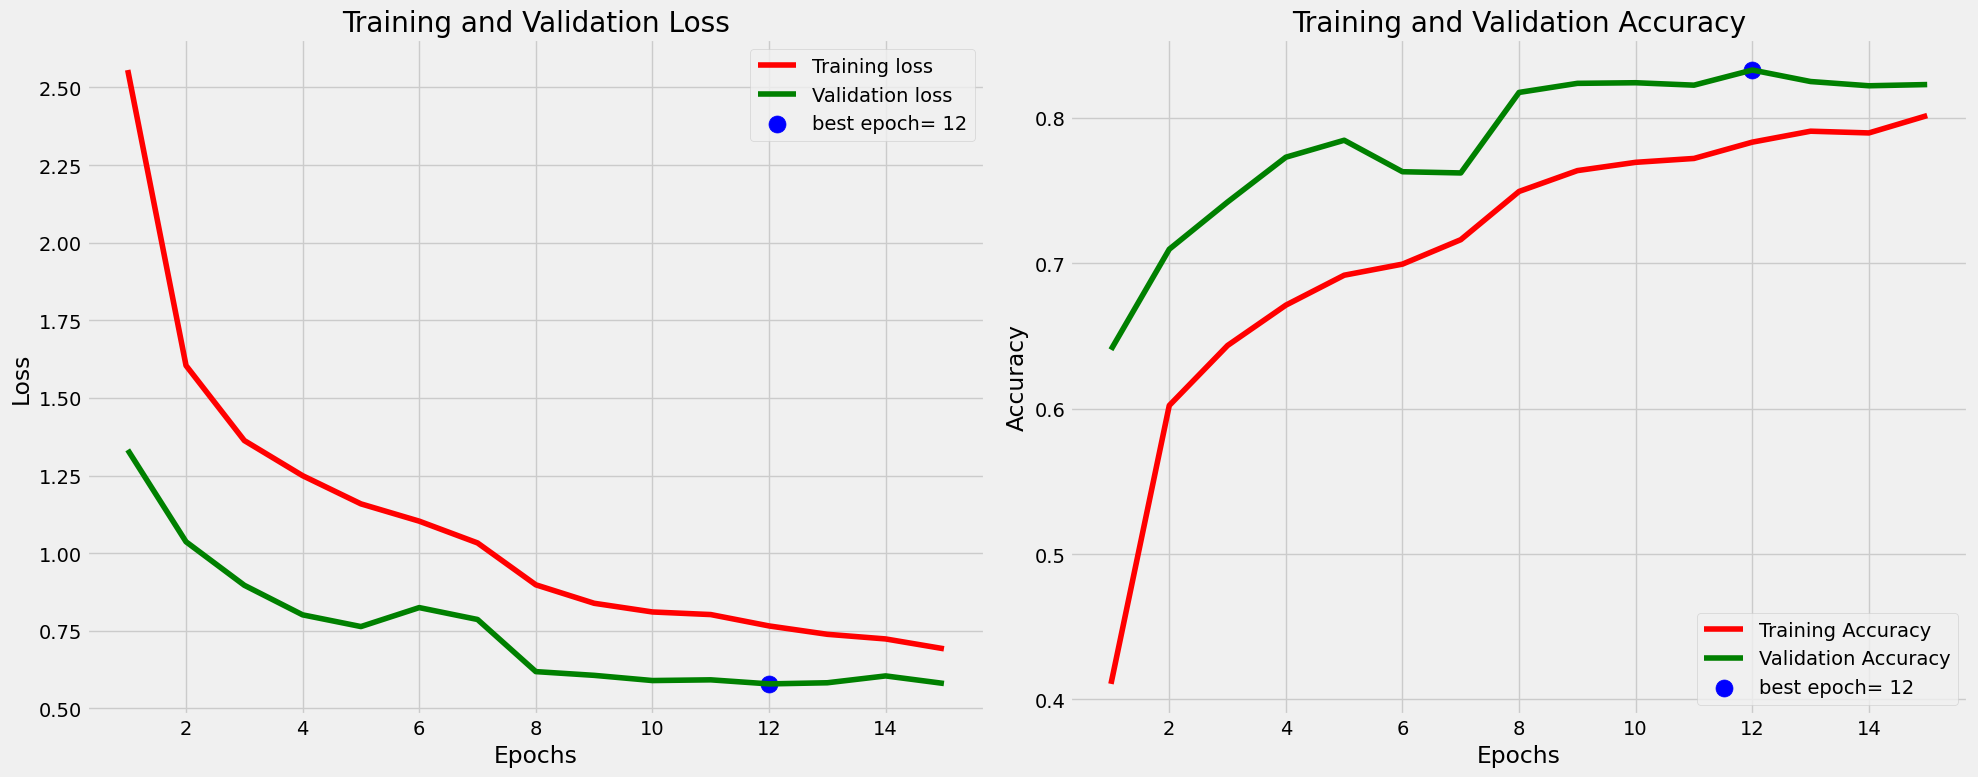

In [117]:
# Define needed variables
tr_acc = history_inception_v3.history['accuracy']
tr_loss = history_inception_v3.history['loss']
val_acc = history_inception_v3.history['val_accuracy']
val_loss = history_inception_v3.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Model Evaluate

In [118]:
results = model_inception_v3.evaluate(test_images_inception_v3, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.54053
Test Accuracy: 84.07%


F1 Score / Recall / Precision

In [119]:
y_true = test_images_inception_v3.classes
y_pred = np.argmax(model_inception_v3.predict(test_images_inception_v3), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_inception_v3.class_indices.keys()))

234/234 [==============================] - 11s 41ms/step
F1 Score: 0.8397862599708954
                       precision    recall  f1-score   support

           air hockey       0.82      0.78      0.80        18
      ampute football       0.90      1.00      0.95        18
              archery       0.83      0.95      0.89        21
        arm wrestling       0.89      1.00      0.94        16
         axe throwing       1.00      0.94      0.97        18
         balance beam       0.79      0.92      0.85        24
        barell racing       0.53      1.00      0.69        20
             baseball       0.68      0.82      0.74        28
           basketball       0.66      0.78      0.71        27
       baton twirling       0.76      0.89      0.82        18
            bike polo       0.57      0.94      0.71        18
            billiards       1.00      1.00      1.00        23
                  bmx       0.78      0.82      0.80        22
              bobsled       0.8

In [122]:
#predict labels on InceptionV3 test_set
preds = model_inception_v3.predict(test_images_inception_v3)
y_pred = np.argmax(preds, axis=1)
true_classes = test_images_inception_v3.classes
class_labels = list(test_images_inception_v3.class_indices.keys())  # Class names

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)

# Calculating the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Displaying class-specific accuracies
for class_label, accuracy in zip(class_labels, accuracies):
    print(f"{class_label}: {accuracy:.2%}")

234/234 [==============================] - 10s 42ms/step
air hockey: 77.78%
ampute football: 100.00%
archery: 95.24%
arm wrestling: 100.00%
axe throwing: 94.44%
balance beam: 91.67%
barell racing: 100.00%
baseball: 82.14%
basketball: 77.78%
baton twirling: 88.89%
bike polo: 94.44%
billiards: 100.00%
bmx: 81.82%
bobsled: 86.36%
bowling: 89.47%
boxing: 89.47%
bull riding: 58.33%
bungee jumping: 85.00%
canoe slamon: 92.31%
cheerleading: 80.95%
chess: 81.25%
chuckwagon racing: 36.84%
cricket: 80.95%
croquet: 100.00%
curling: 100.00%
dance sports: 68.75%
disc golf: 95.00%
esport: 62.50%
fencing: 100.00%
field hockey: 88.00%
figure skating men: 85.71%
figure skating pairs: 66.67%
figure skating women: 92.00%
fly fishing: 86.36%
football (UK): 73.33%
formula 1 racing: 93.33%
frisbee: 80.95%
gaga: 63.16%
giant slalom: 95.83%
golf: 60.00%
hammer throw: 75.00%
hang gliding: 100.00%
harness racing: 100.00%
high jump: 80.00%
hockey: 85.19%
horse jumping: 72.73%
horse racing: 72.73%
horseshoe pitch

#COMPARISON

In [152]:
import pandas as pd

data = {
    'Model': ['ResNet50', 'VGG16', 'MobileNetV3 Large', 'EfficientNetB0', 'InceptionV3'],
    'Accuracy': ["84.63 %", "75.03 %", "90.66 %", "92.16 %", "84.07 %"],
    'F1 Score': [0.84 , 0.75, 0.9, 0.92, 0.84 ],
    'Training Time': ["1533.02s" , "586.28s", "878.49s", "1008.06s", "849.25s" ]
}

df = pd.DataFrame(data)

# Sort the DataFrame by 'Accuracy' in descending order
df = df.sort_values(by='Accuracy', ascending=False)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the ranked table
print(df)

               Model Accuracy  F1 Score Training Time
0     EfficientNetB0  92.16 %      0.92      1008.06s
1  MobileNetV3 Large  90.66 %      0.90       878.49s
2           ResNet50  84.63 %      0.84      1533.02s
3        InceptionV3  84.07 %      0.84       849.25s
4              VGG16  75.03 %      0.75       586.28s
